In [1]:
import numpy as np
import pandas as pd

data = pd.read_stata("data/trust.dta")
data

,ID,date,first_date,last_date,introuble,connection,type,bid_itp,ask_itp,mid_itp,connected,year,prc_log,panic,time,treat_a,treat_c
0,1,1905-01-27,1905-01-27,1909-12-31,0,0.0,normal,115.0,125.0,120.00,0.0,1905.0,4.787492,0.0,1.0,0.0,0.0
1,1,1905-02-24,1905-01-27,1909-12-31,0,0.0,normal,120.0,125.0,122.50,0.0,1905.0,4.808111,0.0,2.0,0.0,0.0
2,1,1905-03-31,1905-01-27,1909-12-31,0,0.0,normal,115.0,125.0,120.00,0.0,1905.0,4.787492,0.0,3.0,0.0,0.0
3,1,1905-04-28,1905-01-27,1909-12-31,0,0.0,normal,125.0,127.5,126.25,0.0,1905.0,4.838264,0.0,4.0,0.0,0.0
4,1,1905-05-26,1905-01-27,1909-12-31,0,0.0,normal,120.0,130.0,125.00,0.0,1905.0,4.828314,0.0,5.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24243,68,1909-08-30,1905-01-27,1909-12-31,0,0.0,normal,135.0,145.0,140.00,0.0,1909.0,4.941642,1.0,407.0,0.0,0.0
24244,68,1909-09-29,1905-01-27,1909-12-31,0,0.0,normal,135.0,145.0,140.00,0.0,1909.0,4.941642,1.0,408.0,0.0,0.0
24245,68,1909-10-29,1905-01-27,1909-12-31,0,0.0,normal,133.0,140.0,136.50,0.0,1909.0,4.916325,1.0,409.0,0.0,0.0
24246,68,1909-11-29,1905-01-27,1909-12-31,0,0.0,normal,133.0,140.0,136.50,0.0,1909.0,4.916325,1.0,410.0,0.0,0.0


In [2]:
import statsmodels.api as sm
#target = data[data.ID==34]
#Y = target.prc_log.to_numpy().copy()
T = 411

donor = data[data.type=='normal']
donor_IDs = set(donor.ID)
Donors = np.zeros((T, len(donor_IDs)-1))
# We need even number of donors. We found the first donor (ID=1) has one fewer time period
# so we decided to drop it so that we have 48 donors
for i, id in enumerate(donor_IDs):
    if i > 0:
        Donors[:,i-1] += donor[donor.ID==id].prc_log.to_numpy()
#Donors = Donors[:, np.random.permutation(Donors.shape[1])]
W = Donors[:,:24]
Z0 = Donors[:,24:]

W = Donors
Z0 = np.zeros(W.shape)
for i, id in enumerate(donor_IDs):
    if i > 0:
        Z0[:,i-1] += np.log(donor[donor.ID==id].bid_itp.to_numpy())

connects = data[data.type=='connected']
connect_ids = sorted(set(connects.ID))


X = np.zeros((T, 3))
Z1 = np.zeros((T, 3))

X[:,0] += np.log(data[data.ID==37].bid_itp.to_numpy())
X[:,1] += np.log(data[data.ID==57].bid_itp.to_numpy())
    
Z1[:,0] += np.log(data[data.ID==37].ask_itp.to_numpy())
Z1[:,1] += np.log(data[data.ID==57].ask_itp.to_numpy())

X[:,-1] = np.log(data[data.ID==34].bid_itp.to_numpy())
Z1[:,-1] = np.log(data[data.ID==34].ask_itp.to_numpy())

Y = data[data.ID==34].prc_log.to_numpy()

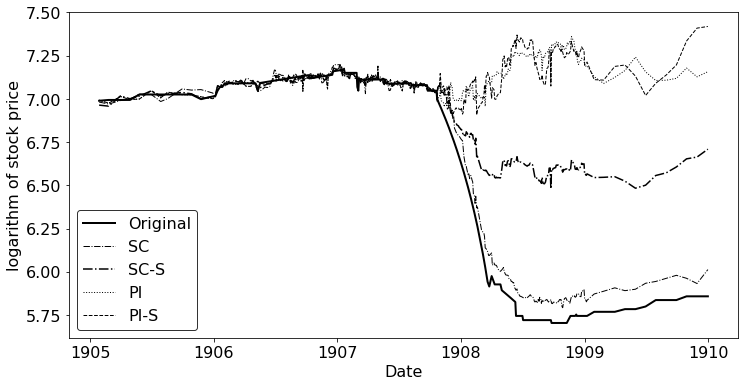

In [3]:
from empirical import EST_extended

lag = 5
est = EST_extended(Y, W, X, Z0, Z1, 229, 182, None, None, None, lag)

import matplotlib.pyplot as plt

# Set font sizes for better readability
plt.rcParams.update({'font.size': 16})

# Create figure and axes objects
fig, ax = plt.subplots(figsize=(12, 6))

# Plot original data
ax.plot(data[data.ID==34].date, Y, label='Original', linestyle='-', linewidth=2, color='black')

# Plot OLS detrended data
tau, taut, alpha, se_tau = est.ols()
ax.plot(data[data.ID==34].date, Y-taut, label='SC', linestyle='-.', linewidth=1, color='black')

# Plot OLS Surrogate detrended data
tau, taut, alpha, se_tau = est.ols_surrogate()
ax.plot(data[data.ID==34].date, Y-taut, label='SC-S', linestyle='-.', linewidth=1.5, color='black')

# Plot PI detrended data
tau, taut, alpha, se_tau = est.pi()
ax.plot(data[data.ID==34].date, Y-taut, label='PI', linestyle=':', linewidth=1, color='black')

# Plot PI Surrogate detrended data
tau, taut, alpha, se_tau = est.pi_surrogate()
ax.plot(data[data.ID==34].date, Y-taut, label='PI-S', linestyle='--', linewidth=1, color='black')

# Set axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('logarithm of stock price')

# Add legend and adjust its properties
legend = ax.legend(loc='lower left')
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')

# Save the figure to a PDF file
fig.savefig('empirical.pdf', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [6]:
from empirical import EST_extended

def est_ts_list(ts_list, Y, W, X, Z0, Z1, lag):
    result = np.zeros((len(ts_list)*2, 5))
    for i, ts in enumerate(ts_list):
        Ys, Ws, Xs, Z0s, Z1s = Y[:229+ts], W[:229+ts], X[:229+ts], Z0[:229+ts], Z1[:229+ts]
        est = EST_extended(Ys, Ws, Xs, Z0s, Z1s, 229, ts-10, None, None, None, lag)
        tau, taut, alpha, se_tau = est.ols()
        result[2*i, 0] = tau
        result[2*i+1, 0] = se_tau
        tau, taut, alpha, se_tau = est.ols_surrogate()
        result[2*i, 1] = tau
        result[2*i+1, 1] = se_tau
        tau, taut, alpha, se_tau = est.pi()
        result[2*i, 2] = tau
        result[2*i+1, 2] = se_tau
        tau, taut, alpha, se_tau = est.pi_surrogate()
        result[2*i, 3] = tau
        result[2*i+1, 3] = se_tau
        tau, taut, alpha, se_tau = est.pi_surrogate_post()
        result[2*i, 4] = tau
        result[2*i+1, 4] = se_tau
    return result

results = est_ts_list([80, 100, 120, 160, 182], Y, W, X, Z0, Z1, 1)
print(results)
np.savetxt('empirical_results2.csv', results, delimiter=',')

[[-0.02010018 -0.37036545 -0.59984531 -0.59305743 -0.73856431]
 [ 0.01401447  0.04305448  0.15397509  0.15387309  1.02727309]
 [-0.01260381 -0.49491904 -0.77114686 -0.76895212 -0.3606489 ]
 [ 0.01185317  0.05145514  0.16285439  0.16062639  1.47648702]
 [-0.06056468 -0.56581136 -0.90860248 -0.92009921 -0.58972694]
 [ 0.01547213  0.0520855   0.16520919  0.16497786  0.3332176 ]
 [-0.0685635  -0.62590244 -1.08609097 -1.08631235 -0.5306454 ]
 [ 0.01602219  0.05022362  0.1690923   0.16564231  0.57830995]
 [-0.08893316 -0.64258954 -1.13778622 -1.13383128 -1.21946267]
 [ 0.02098107  0.04747318  0.1608565   0.15778521  0.52108781]]
